In [1]:
import os
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms


class PairedHDF5Dataset(Dataset):
    def __init__(self, data_dir, 
                 groundtruth_dir):
        super(PairedHDF5Dataset, self).__init__()

        # Get a list of paths
        self.data_paths = sorted(
            [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.hdf5')])
        self.groundtruth_paths = sorted(
            [os.path.join(groundtruth_dir, file) for file in os.listdir(groundtruth_dir) if file.endswith('.hdf5')])

        assert len(self.data_paths) == len(self.groundtruth_paths), "Mismatch between data and groundtruth files"

        # Calculate the cumulative sizes
        self.cumulative_sizes = []
        cum_size = 0
        for path in self.data_paths:
            with h5py.File(path, 'r') as file:
                cum_size += len(file['data'])
                self.cumulative_sizes.append(cum_size)
                
         # Define the image transformation to resize to half of the original size
        self.transform1 = transforms.Resize((1000 //8, 513 // 8))
        self.transform2 = transforms.Resize((362 //8, 362 //8 ))


    def __len__(self):
        return self.cumulative_sizes[-1]

    def __getitem__(self, index):
        # Find the correct file and local index
        file_idx = next(i for i, cum_size in enumerate(self.cumulative_sizes) if cum_size > index)
        if file_idx == 0:
            local_index = index
        else:
            local_index = index - self.cumulative_sizes[file_idx - 1]

        with h5py.File(self.data_paths[file_idx], 'r') as data_file, h5py.File(self.groundtruth_paths[file_idx],
                                                                               'r') as gt_file:
            data = torch.tensor(np.expand_dims(data_file['data'][local_index], axis=0).squeeze())
            groundtruth = torch.tensor(np.expand_dims(gt_file['data'][local_index], axis=0).squeeze())
            
        
        # Resize data and groundtruth to half of the original size
        data = self.transform1(data.unsqueeze(0))
        groundtruth = self.transform2(groundtruth.unsqueeze(0))
        
        return data.squeeze(0), groundtruth.squeeze(0)


# Usage:
train_dataset = PairedHDF5Dataset(
    'observation_train',
    'ground_truth_train'
)

validation_dataset = PairedHDF5Dataset(
    'observation_validation',
    'ground_truth_validation'
)



In [2]:
from torch.utils.data import Subset
import random

# Randomly sample 200 indices from the dataset
i = random.sample(range(len(train_dataset)), 200)
j = random.sample(range(len(validation_dataset)), 20)
# Create a subset from the train_dataset using the sampled indices
subset_dataset = Subset(train_dataset, i)
valsubset_dataset = Subset(validation_dataset, j)


In [3]:
from torch.utils.data import DataLoader

data_loader = DataLoader(subset_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(valsubset_dataset, batch_size=1, shuffle=True)

Matplotlib created a temporary cache directory at /tmp/792439.tinygpu/matplotlib-pzlhsevy because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


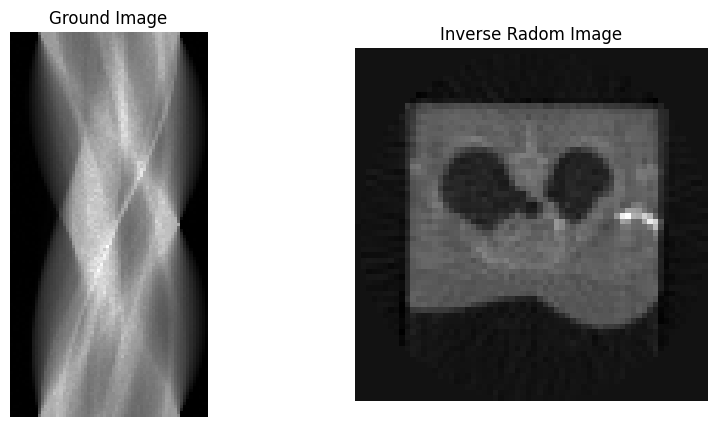

In [4]:
from skimage.transform import iradon
import matplotlib.pyplot as plt

#original_image = torch.zeros((500, 256))
for image, labels in data_loader:
    
    plt.figure(figsize=(10, 5))
    original_image = image[0]
    
    plt.subplot(1, 2, 1)
    plt.imshow(image[0], cmap='gray')
    plt.axis('off')
    plt.title('Ground Image')
    
    plt.subplot(1, 2, 2)
    iradom_image = iradon(image[0].T.numpy(), circle=True)
    plt.imshow(iradom_image, cmap='gray')
    plt.axis('off')
    plt.title('Inverse Radom Image')
    
    plt.show()
    break  

In [5]:
from neuralop.models import FNO
from torch import nn


class FNO_reco(nn.Module):
    def __init__(self):
        super(FNO_reco, self).__init__()

        self.operator0 = FNO(n_modes=(32, 32), hidden_channels=32, in_channels=1, out_channels=1)
        #self.operator1 = FNO(n_modes=(32, 32), hidden_channels=64, in_channels=3, out_channels=1)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((362 // 8, 362 // 8))

    def forward(self, proj):
        rco = self.operator0(proj.unsqueeze(1))
        #rco = self.operator1(rco)
        rco = self.adaptive_pool(rco)

        return rco.squeeze(1)


In [6]:
import torch
torch.cuda.is_available()

True

In [7]:
model = FNO_reco().cuda()

# use GV_Loss + MSE_Loss + Perceptron loss

In [8]:
def L1_regularization(model, lambda_l1):
    l1_loss = sum(p.abs().sum() for p in model.parameters())
    return lambda_l1*l1_loss

In [9]:
import torch.nn as nn

def perceptron_loss(output, target):
    vgg_pretrained_features = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features.cuda()
    slice1 = nn.Sequential()
    for x in range(10):  # 选择前10个卷积层作为特征提取器
        slice1.add_module(str(x), vgg_pretrained_features[x])
    slice1 = slice1
    slice1.eval()  
    for param in slice1.parameters():
        param.requires_grad = False
    
    x_vgg = slice1(output)
    y_vgg = slice1(target)
    loss = torch.mean(torch.abs(x_vgg - y_vgg))
    return loss

In [10]:
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models.vgg import VGG16_Weights
import os

os.environ['TORCH_HOME'] = 'directory'

def gram_matrix(input_tensor):
    """
    计算输入特征图的 Gram 矩阵
    """
    batch_size, channels, height, width = input_tensor.size()
    features = input_tensor.view(batch_size * channels, height * width)
    gram = torch.mm(features, features.t())
    return gram.div(batch_size * channels * height * width)

def style_loss(style_image, generated_image):
    """
    计算风格损失
    """
    # 加载预训练的 VGG16 模型，并选择中间层作为特征提取器
    vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features.cuda().eval()  # 将模型移到GPU上并设置为评估模式
    style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1', 
                    'conv6_1', 'conv7_1', 'conv8_1', 'conv9_1', 'conv10_1', 
                    'conv11_1', 'conv12_1', 'conv13_1', 'conv14_1', 'conv15_1']

    # 提取风格图像和生成图像在指定层的特征
    style_features = []
    generated_features = []
    for name, layer in vgg.named_children():
        style_image, generated_image = layer(style_image), layer(generated_image)
        for name in style_layers:
            style_features.append(style_image)
            generated_features.append(generated_image)

    # 计算风格损失
    style_loss = 0
    for style_feature, generated_feature in zip(style_features, generated_features):
        style_gram = gram_matrix(style_feature)
        generated_gram = gram_matrix(generated_feature)
        loss = torch.mean(torch.square(style_gram - generated_gram))
        style_loss += loss * 1e2

    return style_loss / len(style_features)

In [11]:
# 使用示例
style_image = torch.randn(1, 3, 362, 362).cuda()
generated_image = torch.randn(1, 3, 362, 362).cuda()

loss = perceptron_loss(style_image, generated_image)
print("P Loss:", loss.item())
loss = style_loss(style_image, generated_image)
print("style Loss:", loss.item())

P Loss: 3.8932366371154785
style Loss: 0.00024951115483418107


Epoch [1/15], Train Loss: 0.0219, Val Loss: 0.0136
Epoch [2/15], Train Loss: 0.0132, Val Loss: 0.0127
Epoch [3/15], Train Loss: 0.0126, Val Loss: 0.0121
Epoch [4/15], Train Loss: 0.0120, Val Loss: 0.0123
Epoch [5/15], Train Loss: 0.0093, Val Loss: 0.0073
Epoch [6/15], Train Loss: 0.0068, Val Loss: 0.0065
Epoch [7/15], Train Loss: 0.0057, Val Loss: 0.0056
Epoch [8/15], Train Loss: 0.0050, Val Loss: 0.0053
Epoch [9/15], Train Loss: 0.0043, Val Loss: 0.0049
Epoch [10/15], Train Loss: 0.0039, Val Loss: 0.0048
Epoch [11/15], Train Loss: 0.0035, Val Loss: 0.0047
Epoch [12/15], Train Loss: 0.0033, Val Loss: 0.0046
Epoch [13/15], Train Loss: 0.0031, Val Loss: 0.0046
Epoch [14/15], Train Loss: 0.0030, Val Loss: 0.0046
Epoch [15/15], Train Loss: 0.0030, Val Loss: 0.0046
Finished Training


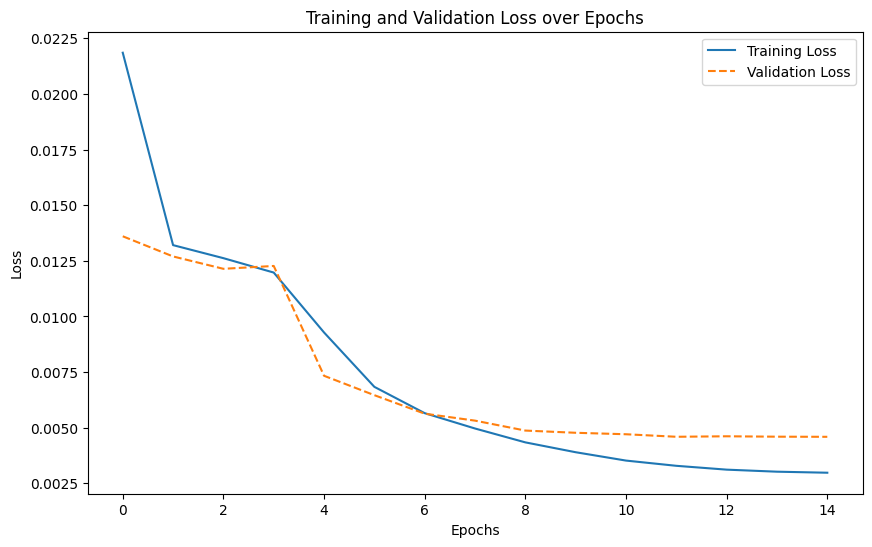

In [12]:
import matplotlib.pyplot as plt
from gradient_variance_loss import GradientVariance
import pytorch_ssim

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(data_loader), epochs=15)
criterion = nn.MSELoss()
grad_criterion = GradientVariance(patch_size = 16, cpu=False)
grad_weight = 0.02
grad_weight = torch.tensor(grad_weight).cuda()
#perceptron_weight = 0.0002
#perceptron_weight = torch.tensor(perceptron_weight).cuda()
num_epochs = 15
lambda_l1 = 5e-10


def train_model(model, data_loader, optimizer, num_epochs, val_loader=None, save_path="best_model.pth"):
    train_loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')  # Initialize with a high value

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_batches = len(data_loader)

        for batch_idx, (data, groundtruth) in enumerate(data_loader):
            data, groundtruth = data.cuda(), groundtruth.cuda()
            optimizer.zero_grad()
            outputs = model(data)
            loss_mse = criterion(outputs, groundtruth)
            loss_grad = grad_weight * grad_criterion(outputs, groundtruth)
            #loss_perceptron = perceptron_weight * perceptron_loss(outputs.unsqueeze(1).repeat(1,3,1,1), groundtruth.unsqueeze(1).repeat(1,3,1,1))
            #ssim_loss =pytorch_ssim.SSIM(window_size = 11)
            #ssim_loss_value = ssim_loss(outputs.unsqueeze(0), groundtruth.unsqueeze(0)).abs()
            #style_loss_value = style_loss(outputs.unsqueeze(0).repeat(1,3,1,1), groundtruth.unsqueeze(0).repeat(1,3,1,1))
            loss = loss_mse + loss_grad
            loss += L1_regularization(model, lambda_l1)
            loss.backward(retain_graph=True)
            optimizer.step()
            running_loss += loss.item()
            scheduler.step()

        avg_train_loss = running_loss / total_batches
        train_loss_history.append(avg_train_loss)

        # Validation phase
        if val_loader:
            model.eval()
            val_running_loss = 0.0
            with torch.no_grad():
                for batch_idx,(data, groundtruth) in enumerate(val_loader):
                    data, groundtruth = data.cuda(), groundtruth.cuda()
                    outputs = model(data)
                    #ssim_loss =pytorch_ssim.SSIM(window_size = 11)
                    #loss_ssim = ssim_loss(outputs.unsqueeze(0), groundtruth.unsqueeze(0)).abs()
                    loss_mse = criterion(outputs, groundtruth)
                    #loss_perceptron = perceptron_weight * perceptron_loss(outputs.unsqueeze(1).repeat(1,3,1,1), groundtruth.unsqueeze(1).repeat(1,3,1,1))
                    #style_loss_value = style_loss(outputs.unsqueeze(0).repeat(1,3,1,1), groundtruth.unsqueeze(0).repeat(1,3,1,1))
                    loss_grad = grad_weight * grad_criterion(outputs, groundtruth)
                    loss = loss_mse + loss_grad
                    val_running_loss += loss.item()

            avg_val_loss = val_running_loss / len(val_loader)

            # Check if this is the best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), save_path)  # Save the best model

            val_loss_history.append(avg_val_loss)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        else:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    print("Finished Training")
    return train_loss_history, val_loss_history


loss_history, val_loss_history = train_model(model, data_loader, optimizer, num_epochs, val_loader)
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()



In [13]:
def load_data_from_hdf5(filename, dataset_name="data"):
    with h5py.File(filename, 'r') as f:
        # Assuming the dataset is 3D and you want the first image
        data = f[dataset_name][-1, :, :]
    return data


phantom = load_data_from_hdf5("ground_truth_test_003.hdf5")
phantom = torch.tensor(np.expand_dims(phantom, axis=0).copy(), dtype=torch.float32).cuda()
sinogram = load_data_from_hdf5("observation_test_003.hdf5")
sinogram = torch.tensor(np.expand_dims(sinogram, axis=0).copy(), dtype=torch.float32).cuda()

In [14]:
model = model.cpu()

In [15]:
model.eval()
reconstruction = model(sinogram.cpu())

In [16]:
import torch

# 检查GPU是否可用
if torch.cuda.is_available():
    # 获取GPU设备
    device = torch.device("cuda")
    
    # 获取GPU设备的数量
    num_gpu = torch.cuda.device_count()
    
    print("Number of GPUs available:", num_gpu)
    
    for i in range(num_gpu):
        # 获取每个GPU的名称
        gpu_name = torch.cuda.get_device_name(i)
        print("GPU", i, ":", gpu_name)
        
        # 获取每个GPU的内存总量和已使用量
        total_memory = torch.cuda.get_device_properties(i).total_memory / 1024**3 # 将内存转换为GB
        allocated_memory = torch.cuda.memory_allocated(i) / 1024**3
        cached_memory = torch.cuda.memory_reserved(i) / 1024**3
        print(f"Total Memory: {total_memory:.2f} GB")
        print(f"Allocated Memory: {allocated_memory:.2f} GB")
        print(f"Cached Memory: {cached_memory:.2f} GB\n")
else:
    print("No GPU available, using CPU instead.")



Number of GPUs available: 1
GPU 0 : NVIDIA GeForce GTX 1080 Ti
Total Memory: 10.91 GB
Allocated Memory: 0.68 GB
Cached Memory: 0.81 GB



In [17]:
def normalize_image(image: np.ndarray) -> np.ndarray:
    """Normalize the pixel values of an image to the range [0, 1]."""
    min_val = image.min()
    max_val = image.max()

    return (image - min_val) / (max_val - min_val)


In [18]:
transform3 = transforms.Resize((362, 362))
reconstruction2 = transform3(reconstruction)
transform4 = transforms.Resize((362//8, 362//8))
phantom2 = transform4((phantom))

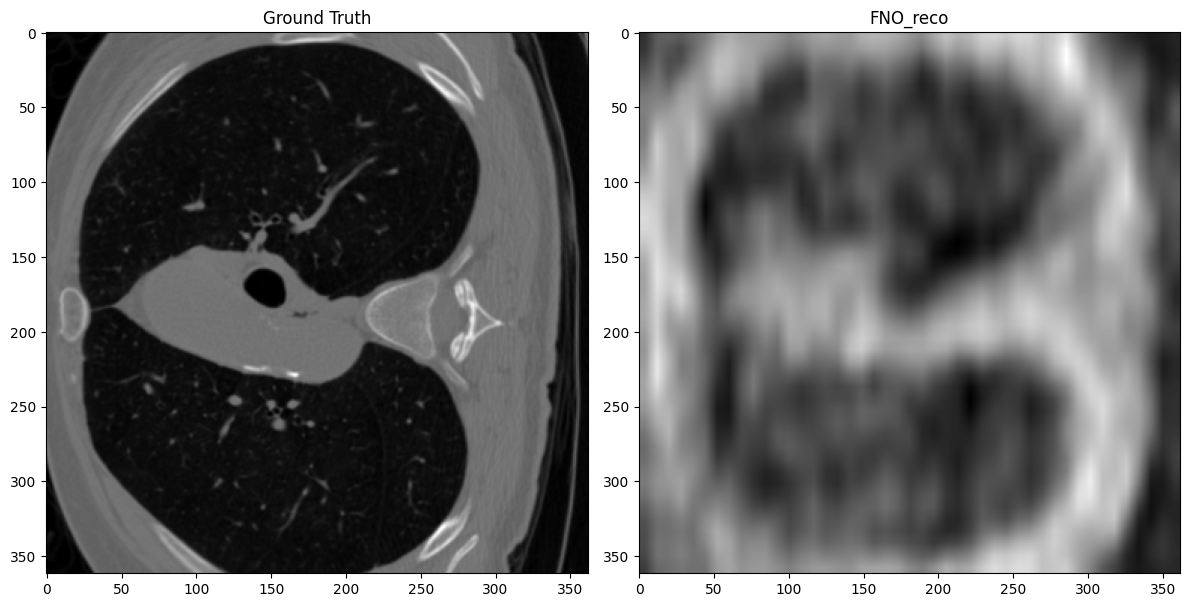

In [19]:
#reconstruction = reconstruction.detach().cpu().numpy().squeeze()
# 1. Display the original Shepp-Logan phantom.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(normalize_image(phantom.squeeze().cpu()), cmap='gray')
plt.title('Ground Truth')

plt.subplot(1, 2, 2)
plt.imshow(normalize_image(reconstruction2.detach().cpu().numpy().squeeze()), cmap='gray')
plt.title('FNO_reco')

plt.tight_layout()
plt.show()